# 3D volume rendering of geophysical data using the yt platform

A notebook submission to the 2020 EarthCube Annual Meeting

To view a static rendering of this notebook, visit https://nbviewer.jupyter.org/github/chrishavlin/yt_velmodel_vis/blob/ecubeNtbook/notebooks/Notebook_3DseismicVis.ipynb

**Authors**: Christopher Havlin<sup>1</sup>,  Benjamin Holtzman<sup>1</sup>, Kacper Kowalik<sup>2</sup>, Madicken Munk<sup>2</sup>, Sam Walkow<sup>2</sup>, Matthew Turk<sup>2</sup> 

1. Lamont-Doherty Earth Observatory, Columbia University 
2. University of Illinois Urbana-Champagne 

## 1. Abstract 

We present novel applications of yt, a tool originally designed for analysis of astrophysics datasets, to the geosciences. yt is a python-based platform for volumetric data, which enables semantically meaningful analysis and visualization. As part of a wider effort to bring yt to the geosciences, we present an initial use-case of yt applied to 3D seismic tomography models of the upper mantle from the IRIS Earth Model Collaboration. While the rendering capabilities of yt can in general be applied directly to 3D geoscience data, we add several graphical elements to the 3D rendering to aid in interpretation of volume renderings including latitude/longitude overlays and shapefile suport for plotting political and tectonic boundaries along the Earth’s surface. In this notebook, we focus on tomographic models of North America and the Western U.S., where high resolution models and rapidly varying seismic properties provide a rich dataset to explore systematically at a range of lengthscales. The notebook demonstrates loading and rendering of IRIS netcdf models, highlighting interesting 3D features of the Western U.S. upper mantle, and goes on to demonstrate how having direct control of the transfer functions used in creating the final volume rendering allows for a more systematic exploration of the role of the visualization method in our interpretation of 3D volumetric data. Finally, we conclude by demonstrating some of the semantically-aware capabilities of yt for analysis purposes, and demonstrate how these tools have cross-disciplinary functionality.

## 2. Background

paragraph: **yt intro**. volume rendering overview. some citations for use in astrophysics, other domains. 

The present work demonstrates a use-case of *yt* in visualizing upper mantle geophysical data. Geophysical data contains rich 3D structure that maps the material properties of the upper mantle, including elastic properties (shear wave and compressional wave velocities, attenuation) and electrical properties (conductivity or restitivity). While 3D structure is inherent to all geophysical datasets, 3D visualization is not commonly used by researches and most studies use 2D slices through the 3D data. In the occasional studies where 3D visualization is used, authors rely on 3D isosurfaces (e.g., Obreski et al. 2010) and while isosurfaces can reveal 3D structure, the "noisy" (noisy in a natural sense... find a better word) nature of the data means that small differences in the value chosen for an isosurface can result in significantly different structure. As opposed to rendering isosurfaces, 3D volume rendering (using *yt*) allows the user to map a range of values and systematically explore how their choices influence their final interpretation.

In this notebook, we focus on a single tomographic model **NWUS11-S**, which maps shear wave velocity anomalies, $dV_s$, in the northwest United States (James et al., 2011). The upper mantle beneath the northwest U.S. contains rapid variations in material properties due to the wide range of regional tectonic processes including subduction of the Pacific plate beneath the Cascades and voluminious volcanic activity for the past ~50 Myrs including the Yellowstone Hot Spot (citation). This way in which the surficial tectonic processes map to upper mantle variability provides insights into the processes driving mantle convection and plate tectonics. Additionally,  **NWUS11-S** leveraged data from the Earthscope‐USArray seismic network to achieve a relatively high spatial resolution of the regional upper mantle, providing an ideal set of data to test *yt* in visualizing seismic data. Furthermore, because **NWUS11-S** is one of the models included in the Incorporated Research Institutions for Seismology (IRIS) Earth Model Collaboration (EMC) using the standardized netCDF format for 3-D models (citation), the code developed in the present repository is reasonably general and other models can be easily loaded.

## 3. Overview of Notebook

overview of what this notebook does exactly


We begin by importing the libraries and setting required environment variables. In addition to the standard `yt` library, the present notebook relies on a supplementary `yt_seismic` library (https://github.com/chrishavlin/yt_seismic, the home of the present notebook) that facilates data loading and transformations as described below.

In [4]:
# imports and initialization (not editable)
import os, yt, numpy as np
import matplotlib.pyplot as plt
from yt_velmodel_vis import seis_model as SM,shapeplotter as SP, transferfunctions as TFs
from IPython.display import Image 

os.environ['YTVELMODELDIR']='./data' # local repo path to data directory 

## 4. Loading IRIS Earth Model Collaboration (EMC) Files

The IRIS EMC provides a rich database of geophysical models to test the functionality of *yt*. The 3D EMC models are standardized netCDF files containing models... 

Overwview of types of files/meshes yt works well with. http://ds.iris.edu/ds/products/emc/ 

IRIS EMC files are standardized netcdf files with geophysical data in geo-spherical coordinates (latitude, longitude and depth).


#### Interpolation 
At present, 3D volume rendering in yt is restricted to cartesian coordinates. A spherical rendering module is in development, but for the current demonstration we interpolate from spherical to cartesian coordinates. The `yt_velmodel_vis.seis_model` module contains a KDTree-Inverse Distance Weighting algorithm to populate values on the cartesian grid by finding the nearest model data and weighting it. The resolution of the cartesian grid, number of nearest neighbors and max distance allowed in the nearest neighbor search are all parameters. 

Because the interpolation from spherical to cartesian coordinates is computationally demanding, the current notebook loads a pre-built interpolation included in the respository data directory (`notebooks/data/`) for **NWUS11-S**, defined by the interpolation dictionary (`interp_dict`) in the following code cell. 

In [2]:
# load interpolated data using the yt uniform grid loader (not editable)

# load the pre-built interpolated model
datafld='dvs' # the field to visualize 
interp_dict={'field':'dvs','max_dist':50000,'res':[10000,10000,10000],
              'input_units':'m','interpChunk':int(1e7)}
model=SM.netcdf('NWUS11-S_percent.nc',interp_dict)
bbox = model.cart['bbox'] # the bounding box of interpolated grid in cartesian coordinates
data={datafld:model.interp['data'][datafld]} # data container for yt scene

# load the data as a uniform grid, create the 3d scene
ds = yt.load_uniform_grid(data,data[datafld].shape,1.0,bbox=bbox,nprocs=1,
                        periodicity=(True,True,True),unit_system="mks")
print("Data loaded.")

yt : [INFO     ] 2020-05-08 13:04:59,207 Parameters: current_time              = 0.0
yt : [INFO     ] 2020-05-08 13:04:59,208 Parameters: domain_dimensions         = [287 271 237]
yt : [INFO     ] 2020-05-08 13:04:59,208 Parameters: domain_left_edge          = [-5201282.   -3445670.25  2740212.5 ]
yt : [INFO     ] 2020-05-08 13:04:59,209 Parameters: domain_right_edge         = [-2328344.5     -735306.5625  5113796.5   ]
yt : [INFO     ] 2020-05-08 13:04:59,209 Parameters: cosmological_simulation   = 0.0


Data loaded.


### Loading IRIS EMC Files: Building the scene 

The `yt.scene` object contains the information on how and what to render. In addition to specifying which field of the data to render, we can add annotations. While *yt* has methods for adding annotations to a volume rendering, because we want to add annotations reflecting the original spherical domain, we use routines in the `yt_velmodel_vis` library to manually add annotations as line and point sources.

Additionally, as opposed to the astrophysical datasets that *yt* was originally designed for, interpretation of geophysical datasets typically requires correlation along one boundary of the 3D data. The surficial expression of plate tectonics is directly related to the material properties of the underlying mantle, and so any 3D visualization of geophysical data requires some level of mapping to the regional tectonics at the Earth's surface. And so the `yt_velmodel_vis.shapeplotter` module contains routines to facilitate plotting shapes at the Earth's surface in the 3D view including latitude and longitude grids and automated parsing and transformation of shapefiles. The `shapeplotter` modulue leverages the `geopandas` library for automating the reading of shapefiles and includes transformations from geo-spherical coordinates to geocentric cartesian coordinates. 

In the present visualizations, we include tectonic boundaries (cite), sites of recent volcanism (cite) and US political boundaries (cite). 

In [3]:
def build_yt_scene():
    """ builds the yt scene: 
    
    - Draws the spherical chunk bounding the dataset 
    - Draws a latitude/longitude grid at surface
    - Draws shapefile data: US political boundaries, tectonic boundaries, volcanos 
    
    """
    
    # create the scene 
    sc = yt.create_scene(ds,datafld)    
    
    # specifiy the bounds of the spherical chunk: used for annotating the domain and for limiting
    # the shapefile data on initial read 
    lat_rnge=[np.min(model.data.variables['latitude']),np.max(model.data.variables['latitude'])]
    lon_rnge=[np.min(model.data.variables['longitude']),np.max(model.data.variables['longitude'])]
    min_dep=0.
    max_dep=1200.
    R=6371.
    r_rnge=[(R-max_dep)*1000.,(R-min_dep)*1000.]
    
    # build the spherical chunk, add domain extents and lat,lon grid annotations 
    Chunk=SP.sphericalChunk(lat_rnge,lon_rnge,r_rnge)
    sc=Chunk.domainExtent(sc,RGBa=[1.,1.,1.,0.002],n_latlon=100,n_rad=50)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.005])
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-410.)*1000.)
    sc=Chunk.latlonGrid(sc,RGBa=[1.,1.,1.,0.002],radius=(R-max_dep)*1000.)
    sc=Chunk.wholeSphereReference(sc,RGBa=[1.,1.,1.,0.002])

    # Shapefile data
    
    # set the surficial bounding box, used for reading all shapefiles
    shp_bbox=[lon_rnge[0],lat_rnge[0],lon_rnge[1],lat_rnge[1]] 

    # US political boundaries 
    for shpfi in ['us_states']:
        thisshp=SP.shapedata(shpfi,bbox=shp_bbox,radius=R*1000.)
        sc=thisshp.addToScene(sc)

    # tectonic boundaries: buid a dictionary with unique RGBa values for each
    clrs={
        'transform':[0.8,0.,0.8,0.05],
        'ridge':[0.,0.,0.8,0.05],
        'trench':[0.8,0.,0.,0.05],
        'global_volcanos':[0.,0.8,0.,0.05]
    }
    for bound in ['transform','ridge','trench','global_volcanos']:
        tect=SP.shapedata(bound,radius=R*1000.,buildTraces=False)
        sc=tect.buildTraces(RGBa=clrs[bound],sc=sc,bbox=shp_bbox)
        
    return sc   

The view is controlled by the camera object of a scene. 

In [4]:
def setCamera(sc):
    pos=sc.camera.position
    Rmax=6371*1000.
    center_vec=np.array([np.mean(bbox[0])/Rmax,np.mean(bbox[1])/Rmax,np.mean(bbox[2])/Rmax])
    sc.camera.set_position(pos,north_vector=center_vec)

    res=sc.camera.get_resolution()
    res_factor=1
    new_res=(int(res[0]*res_factor),int(res[1]*res_factor))
    sc.camera.set_resolution(new_res)

    zoom_factor=0.7 # < 1 zooms in
    init_width=sc.camera.width
    sc.camera.width = (init_width * zoom_factor)
    sc.camera.rotate(0*np.pi/180)

## Transfer Functions

**Overview of 3D volume rendering in yt:** 3D volume rendering in `yt` uses ray-tracing through the 3D volume: rays are passed through the volume sources within a scene to the camera and the final RGB value of each pixel in the image is an integration of the RGBa values along each raypath. The **transfer function** maps the value of the data field at each voxel to an RGBa value, determining how much an individual voxel contributes to the final composite.

The following image contains an example of a transfer function (left) and volume rendering (right): 

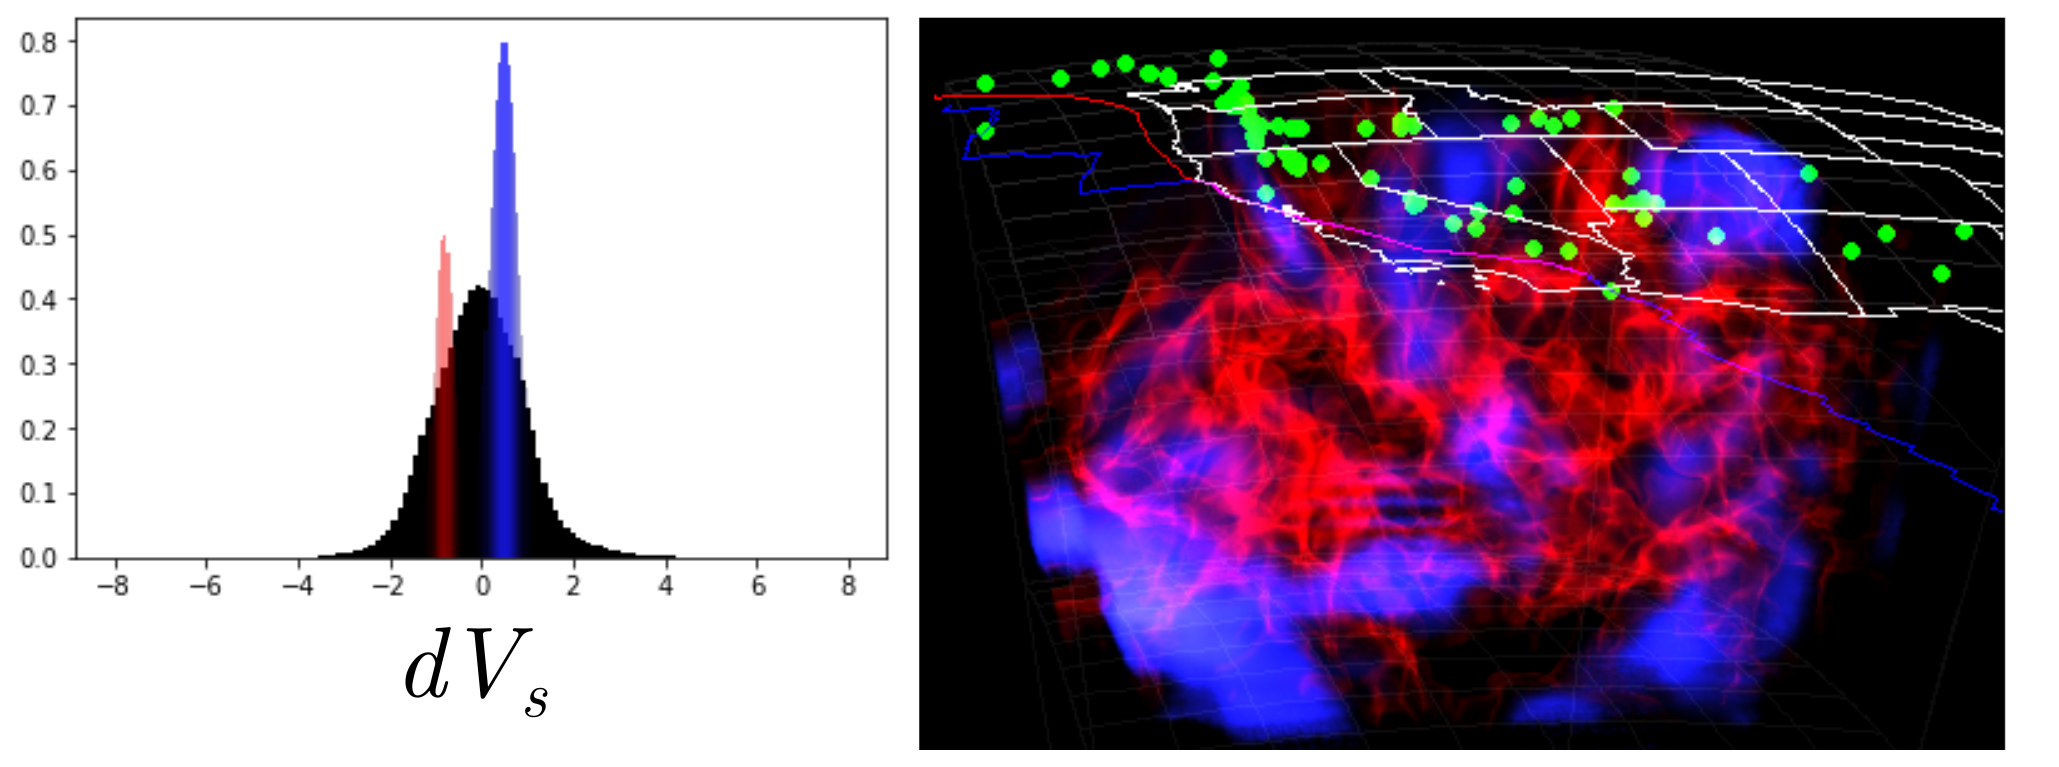

In [3]:
Image(filename = os.path.join('resources','TFexample.png'))

The transfer function plot (left) contains a normalized histogram of the velocity anomaly, $dV_s$, over the whole domain, in black. The red and blue guassians represent the transfer function: the y-axis corresponds to the transmission coefficient (0 for transparent, 1 for opaque) and the $dV_s$ values falling within each respective gaussian are assigned the corresponding RGB value. 

The given transfer function results in the volume rendering to the right. **Describe it briefly.**

In the following sections, we demonstrate how to create the above figure, and then how to modify the transfer function in more complex ways.

### Transfer Functions: yt presets

*yt* provides a variety of preset transfer functions, but first, we define a simple function to pull out the values from a given transfer function to plot on top of a histogram of the data:

In [5]:
def plotTf_yt(tf,dvs_min,dvs_max):     
    x = np.linspace(dvs_min,dvs_max,tf.nbins) # RGBa value defined for each dvs bin in range
    y = tf.funcs[3].y # the alpha value of transfer function at each x 
    w = np.append(x[1:]-x[:-1], x[-1]-x[-2]) 
    colors = np.array([tf.funcs[0].y, tf.funcs[1].y, tf.funcs[2].y,
                       tf.funcs[3].y]).T
    fig = plt.figure()
    ax = fig.add_axes([0.2, 0.2, 0.75, 0.75])
    d_hist=ax.hist(data['dvs'][~np.isnan(data['dvs'])].ravel(),bins=100,density=True,log=False,color='k')
    ax.bar(x, tf.funcs[3].y, w, edgecolor=[0.0, 0.0, 0.0, 0.0],
           log=False, color=colors, bottom=[0])
    plt.show()

One of the simplest *yt* trasnfer function methods is to add a gaussian to highlight a narrow range of the data. The user initializes a transfer function, and then adds a gaussian described by the center of the peak, the peak width and the RGBa value of the center point:

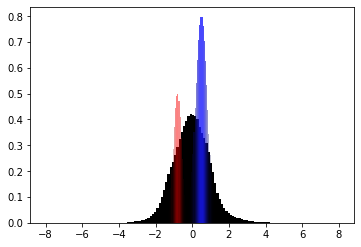

In [21]:
# initialize the tf object by setting the data bounds to consider
dvs_min=-8
dvs_max=8 
tf = yt.ColorTransferFunction((dvs_min,dvs_max))

# set gaussians
TF_gaussians=[
    {'center':-.8,'width':.1,'RGBa':(1.,0.,0.,.5)},
    {'center':.5,'width':.2,'RGBa':(0.1,0.1,1.,.8)}
]

for gau in TF_gaussians:
    tf.add_gaussian(gau['center'],gau['width'],gau['RGBa'])
    
# plot the transfer function     
plotTf_yt(tf,dvs_min,dvs_max)

Once the transfer function is set, the volume rendering can be created. Because we will explore different transfer functions below, we first define a function to build the yt scene object. 

In [7]:
def configure_scene(the_transfer_function):
    # build scene, apply camera settings, set the transfer function 
    sc = build_yt_scene() 
    setCamera(sc)
    source = sc.sources['source_00']
    source.set_transfer_function(the_transfer_function)
    print("Scene ready to render")
    return sc

In [22]:
sc = configure_scene(tf)

Scene ready to render


The scene is now ready to render, which is done by calling `sc.show()`.

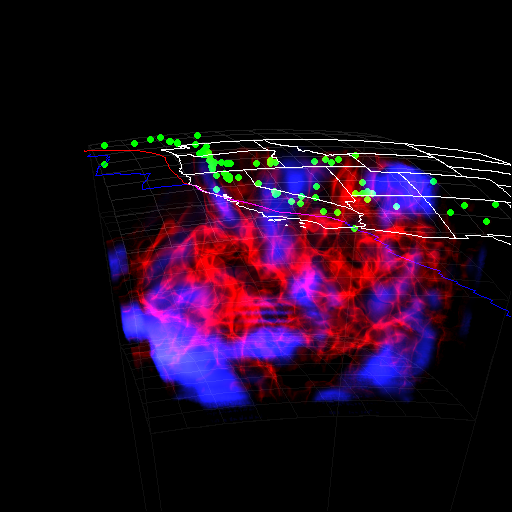

In [33]:
sc.show(sigma_clip=1.5)

Note that the argument `sigma_clip=1.5` controls the contrast of the final image, which is useful for fine tuning the final brightness of the image (e.g., https://yt-project.org/doc/cookbook/complex_plots.html#cookbook-sigma-clip). 

### Transfer Functions: Customization

Because the transfer function object is simply a 4D numpy array of RGBa values, it is straightforward to create custom transfer functions for a particular application. Here, we demonstrate a more complex transfer function built to clearly differentiate slow and fast anomalies over a wider range of data than the gaussian example. This example uses some transfer function routines from the `yt_velmodel_vis.transfer_functions` module and so we define a new plotting function before building the transfer function:

In [10]:
def plotTf(tfOb):
    """ create a histogram-transfer function plot and display it"""
    f=plt.figure()
    ax=plt.axes()
    ax=tfOb.addHist(ax=ax,density=True,color=(0.,0.,0.,1.))
    ax=tfOb.addTFtoPlot(ax=ax)
    ax.set_xlabel('dvs')        
    plt.show()

Now that we have a way to visualize transfer functions, we can build a transfer function. This example divides the transfer function into two separate segments of the data using entirely different colormaps. Within each segmemt, the transmission coefficient is inversely proportional to the number of observations in that $dV_s$ bin,

$\alpha(dV_s^i) = \alpha_0 - \Delta{\alpha} \frac{N(dV_s^i)}{\mathrm{max}(N(dV_s))}$

where $\alpha_0$ is the maximum transmission coefficient, $\Delta{\alpha}$ is the reduction in transmission coefficient, $N(dV_s)$ is value of the normalized histogram of $dV_s$ observations and $N(dV_s^i)$ is the histogram evaluated at a single $dV_s$ value,  $dV_s^i$. 

This transfer function provides a convenient means to render a wider data range without overwhelming the image with the anomalies near 0.

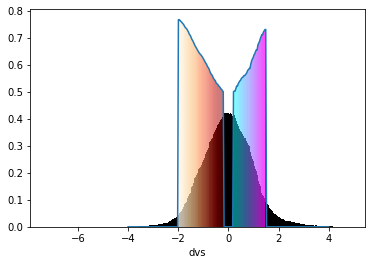

Ready to build scene


In [11]:
# setting up transfer functions 
tfOb = TFs.dv(data[datafld].ravel(),bounds=[-4,4])

def alphaHist(histData,maxAlpha,alphaFac):
    if alphaFac>maxAlpha:
        alphaFac=maxAlpha
    return maxAlpha - alphaFac*histData/histData.max()

bnds=[-2,-.2]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='OrRd')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

bnds=[.2,1.5]
TFseg=TFs.TFsegment(tfOb,bounds=bnds,cmap='cool')
histData,_=tfOb.calcHist(bin_edges=TFseg.dvbins)
tfOb.addTFsegment(alphaHist(histData,.8,0.3),TFseg)

plotTf(tfOb)
print("Ready to build scene")


In [12]:
# build scene, apply camera settings, set the transfer function 
sc = configure_scene(tfOb.tf)

Scene ready to render


yt : [INFO     ] 2020-05-08 13:05:06,771 Rendering scene (Can take a while).
yt : [INFO     ] 2020-05-08 13:05:06,998 Creating volume


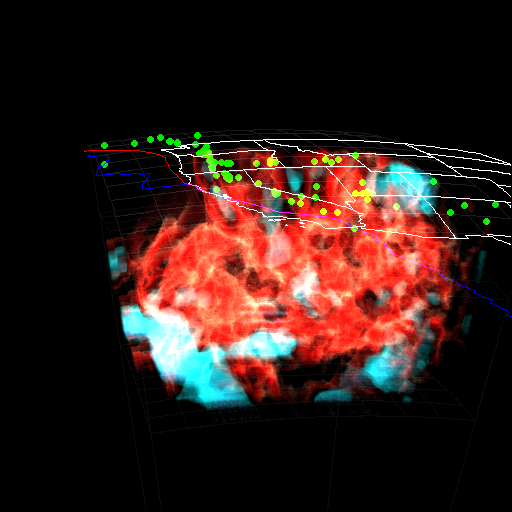

In [13]:
# actually render the scene 
sc.show(sigma_clip=1)

## References

* yt: https://yt-project.org 
* yt_velmodel_vis: https://github.com/chrishavlin/yt_velmodel_vis
* IRIS EMC: http://ds.iris.edu/ds/products/emc-earthmodels/
* IRIS data models Trabant, C., A. R. Hutko, M. Bahavar, R. Karstens, T. Ahern, and R. Aster (2012), Data Products at the IRIS DMC: Stepping Stones for Research and Other Applications, Seismological Research Letters, 83(5), 846–854, https://doi.org/10.1785/0220120032.
* James D.E., M.J. Fouch, R.W. Carlson and J.B. Roth. 2011. “Slab fragmentation, edge flow and the origin of the Yellowstone hotspot track.” Earth Planet. Sci. Lett., https://doi.org/10.1016/j.epsl.2011.09.007. Data retrieved from http://ds.iris.edu/ds/products/emc-nwus11-s/ 
* Obrebski, M., R.M. Allen, M. Xue, and Shu-Huei Hung. 2010. “Slab-Plume Interaction beneath the Pacific Northwest.” Geophys. Res. Lett. 37:L14305. https://doi.org/10.1029/2010GL043489.